# Explicit Factor Model [Zhang et al]

In [2]:
import pickle
import time
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from multiprocessing import Pool

from scipy.sparse import lil_matrix, csr_matrix, csc_matrix
from scipy.sparse import vstack

import sys

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

## データ読み込み

- posi and nega  
- train/test split

In [53]:
posi_data = pickle.load(open('./dataset/posi_data.pickle', 'rb'))
nega_data = pickle.load(open('./dataset/nega_data.pickle', 'rb'))

train_num = int(0.8 * len(posi_data))
train_posi = posi_data[:train_num]
test_posi = posi_data[train_num:]
train_nega = nega_data[:train_num]
test_nega = nega_data[train_num:]

train_data = np.concatenate([train_posi, train_nega])

In [54]:
target_train = np.array([1 for i in range(len(train_posi))] + [0 for i in range(len(train_nega))])
target_test = np.array([1 for i in range(len(test_posi))] + [0 for i in range(len(test_nega))])

- aspect

In [41]:
user_aspect_dict = pickle.load(open('./dataset/aspect/user_aspect_dict.pickle', 'rb'))
item_aspect_dict = pickle.load(open('./dataset/aspect/item_aspect_dict.pickle', 'rb'))

- dict

In [64]:
user2idx = pickle.load(open('./dataset/user_item_dict/user2idx.pickle', 'rb'))
item2idx = pickle.load(open('./dataset/user_item_dict/item2idx.pickle', 'rb'))

## Model定義

In [19]:
# https://www.kaggle.com/gennadylaptev/factorization-machine-implemented-in-pytorch
class Zhang(nn.Module):
    def __init__(self, user_num, item_num, aspect_num, embed_size1, embed_size2):
        super().__init__()
        
        self.embed_u1 = nn.Embedding(user_num, embed_size1)
        self.embed_u2 = nn.Embedding(user_num, embed_size2)
        self.embed_i1 = nn.Embedding(item_num, embed_size1)
        self.embed_i2 = nn.Embedding(item_num, embed_size2)
        self.lin = nn.Linear(embed_size1, aspect_num)

        
    def forward(self, user_id, item_id):
        u_v1 = self.embed_u1(user_id)
        u_v2 = self.embed_u2(user_id)
        i_v1 = self.embed_u1(item_id)
        i_v2 = self.embed_u2(item_id)
        
        pred_asp_u = self.lin(u_v1)
        pred_asp_i = self.lin(i_v1)
        
        prob = torch.cat([i_v1, i_v2], dim=1) * torch.cat([u_v1, u_v2], dim=1)
        prob = torch.sigmoid(torch.sum(prob, dim=1))
        
        #out = torch.sigmoid(out.view(batch_size))
        
        return prob, pred_asp_u, pred_asp_i
    
    def predict(self, user_id, item_id):
        u_v1 = self.embed_u1(user_id)
        u_v2 = self.embed_u2(user_id)
        i_v1 = self.embed_u1(item_id)
        i_v2 = self.embed_u2(item_id)
        
        prob = torch.cat([i_v1, i_v2], dim=1) * torch.cat([u_v1, u_v2], dim=1)
        prob = torch.sigmoid(torch.sum(prob, dim=1))
        
        return prob

In [23]:
user_num = len(user2idx)
item_num = len(item2idx)
aspect_num = 6
embed_size1 = 2
embed_size2 = 3
model = Zhang(user_num, item_num, aspect_num, embed_size1, embed_size2)

In [24]:
model(torch.tensor([0, 1], dtype=torch.long), torch.tensor([0, 1], dtype=torch.long))

(tensor([0.9987, 0.9899], grad_fn=<SigmoidBackward>),
 tensor([[-0.3433, -0.7572,  1.7805, -0.1548,  0.2666,  0.3324],
         [ 0.2861, -0.8542,  1.9039, -0.4043,  0.7664, -0.4774]],
        grad_fn=<AddmmBackward>),
 tensor([[-0.3433, -0.7572,  1.7805, -0.1548,  0.2666,  0.3324],
         [ 0.2861, -0.8542,  1.9039, -0.4043,  0.7664, -0.4774]],
        grad_fn=<AddmmBackward>))

In [14]:
prob, _, _ = model(torch.tensor([0, 1], dtype=torch.long), torch.tensor([0, 1], dtype=torch.long))
prob

tensor([0.9987, 0.9899], grad_fn=<SigmoidBackward>)

## 学習

In [25]:
def train(model, optimizer, loss_func, aspect_loss_func, input_tensor, target, target_aspect_u, target_aspect_i):
    
    optimizer.zero_grad()

    #score = model(batch_path, batch_relation, batch_type, path_num)
    prob, aspect_u, aspect_i = model(input_tensor[0], input_tensor[1])
    #print(score)
    
    
    # 損失を計算
    # aspectの二乗誤差と、リンク予測の分類誤差 
    loss = loss_func(prob, target)
    aspect_loss = aspect_loss_func(aspect_u, target_aspect_u)
    aspect_loss += aspect_loss_func(aspect_i, target_aspect_i)
    total_loss = loss + aspect_loss
    
    # 勾配を計算
    total_loss.backward()
    
    
    # 勾配降下
    optimizer.step()
    
    
    return float(loss)

In [44]:
def test_train():
    user_num = len(user2idx)
    item_num = len(item2idx)
    aspect_num = 6
    embed_size1 = 2
    embed_size2 = 3
    model = Zhang(user_num, item_num, aspect_num, embed_size1, embed_size2)
    
    optimizer = optim.Adam(model.parameters())
    loss_func = nn.BCELoss()
    aspect_loss = nn.MSELoss()
    
    input = (torch.tensor([0, 1], dtype=torch.long), torch.tensor([0, 1], dtype=torch.long))
    target = torch.tensor([1, 0], dtype=torch.float)
    target_aspect_u = torch.stack([torch.tensor(user_aspect_dict[0]), torch.tensor(user_aspect_dict[1])])
    target_aspect_i = torch.stack([torch.tensor(item_aspect_dict[0]), torch.tensor(item_aspect_dict[1])])
    
    loss = train(model, optimizer, loss_func, aspect_loss, input, target, target_aspect_u, target_aspect_i)
    print(loss)

test_train()

5.212587833404541


## イテレータ

In [61]:
def iterate_train(model, n_iter=30, batch_size=2, learning_rate=0.001, print_every=60, plot_every=30):
    
    print_loss_total = 0
    plot_loss_total = 0
    plot_loss_list = []
    
    start_time = time.time()
    
    # 損失関数定義
    loss_func = nn.BCELoss()
    aspect_loss = nn.MSELoss()
    
    # optimizer 定義
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.002)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # ここから学習
    loss = 0
    for i in range(1, n_iter+1):
        # batchをつくる
        user_id, item_id, target_aspect_u, target_aspect_i, target_batch = get_batch(train_data, target_train, batch_size)
        
        #if len(batch_path_tensor) == 0: continue #pathが一つも取得されなかった場合

        # train
        input_tensor = [user_id, item_id]
        loss = train(model, optimizer, loss_func, aspect_loss, input_tensor, target_batch, target_aspect_u, target_aspect_i)
        print_loss_total += loss
        plot_loss_total += loss
        
        # print_everyごとに現在の平均のlossと、時間、dataset全体に対する進捗(%)を出力
        if i % print_every == 0:
            runtime = time.time() - start_time
            mi, sec = time_since(runtime)
            avg_loss = print_loss_total / print_every
            data_percent = int(i * batch_size / train_data.shape[0] * 100)
            print('train loss: {:e}    processed: {}({}%)    {}m{}sec'.format(avg_loss, i*batch_size, data_percent, mi, sec))
            print_loss_total = 0
        
        # plot_everyごとplot用のlossをリストに記録しておく
        if i % plot_every == 0:
            avg_loss = plot_loss_total / plot_every
            plot_loss_list.append(avg_loss)
            plot_loss_total = 0
            

    return plot_loss_list
    # return print_loss_total

In [60]:
def get_batch(data, target, batch_size):
    
    idx = np.random.randint(0, len(data), batch_size) #重複をゆるしている
    user_id = []
    item_id = []
    user_aspect = []
    item_aspect = []
    
    for path in data[idx]:
        user_id.append(path[1])
        item_id.append(path[0])
        user_aspect.append(user_aspect_dict[path[1]])
        item_aspect.append(item_aspect_dict[path[0]])
        
    user_id = torch.tensor(user_id, dtype=torch.long, device=device)
    item_id = torch.tensor(item_id, dtype=torch.long, device=device)
    user_aspect = torch.tensor(user_aspect, device=device)
    item_aspect = torch.tensor(item_aspect, device=device)
    
    batch_target = torch.tensor(target[idx], dtype=torch.float, device=device)
    
    return user_id, item_id, user_aspect, item_aspect, batch_target

In [56]:
get_batch(train_data, target_train, 2)

(tensor([3159, 1533]),
 tensor([357, 391]),
 tensor([[1.0000, 1.0000, 0.9991, 1.0000, 1.0000, 1.0000],
         [0.8808, 0.9526, 0.8808, 0.8808, 0.7311, 0.8808]]),
 tensor([[1.0000e+00, 1.0000e+00, 7.6392e-07, 9.9940e-01, 9.9941e-01, 9.2838e-01],
         [1.0000e+00, 9.8945e-01, 1.0000e+00, 7.8501e-04, 1.0000e+00, 1.0000e+00]]),
 tensor([0., 1.]))

In [63]:
def test_iterate():
    user_num = len(user2idx)
    item_num = len(item2idx)
    aspect_num = 6
    embed_size1 = 2
    embed_size2 = 3
    model = Zhang(user_num, item_num, aspect_num, embed_size1, embed_size2).to(device)

    iterate_train(model, n_iter=3)
    
test_iterate()

## Ranking評価

In [82]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [83]:
%%cython
def get_user_rankinglist(data, int target_user):
    ranking_list = []
    for d in data:
        if target_user == d[0] or target_user == d[-1]:
            ranking_list.append(d)
    
    return ranking_list

SyntaxError: invalid syntax (<ipython-input-83-bb9c0c34fa39>, line 1)

In [73]:
get_user_rankinglist(test_posi, 1)

[array([   1, 5120]),
 array([   1, 5368]),
 array([   1, 5369]),
 array([   1, 5370]),
 array([   1, 5371]),
 array([   1, 5372]),
 array([   1, 5373]),
 array([   1, 5374])]

In [24]:
def batch2id(batch_data):
    user_id = []
    item_id = []
    for data in batch_data:
        user_id.append(user2idx[data[0]])
        item_id.append(item2idx[data[1]])
        
    return user_id, item_id

In [75]:
def evaluate_ranking(model, metric='ndcg', max_item_num=20, stop_count = len(user2idx)+1):
    with torch.no_grad():
        #以下をforで回す
        ranking_score_list = []
        ranking_score_list1 = []
        ranking_score_list2 = []
        count = 0

        for idx in range(len(user2idx)):

            # あるuserのposiなランキングリストをテストデータから持ってくる
            # nega なランキングリストも持ってくる
            posi_ranking_list = get_user_rankinglist(test_posi, idx)
            nega_ranking_list = get_user_rankinglist(test_nega, idx)
            
            # ranking_listを取得できなかった場合
            if len(posi_ranking_list) == 0 or len(nega_ranking_list) == 0:
                continue

            # ランキングリストをバッチ化
            batch_data = np.array(posi_ranking_list + nega_ranking_list)
            target_batch = [1 for i in range(len(posi_ranking_list))] + [0 for i in range(len(nega_ranking_list))]
            

            # modelに入力できる形にする
            user_id = torch.tensor([usr for usr in batch_data[:, 0]], dtype=torch.long, device=device)
            item_id = torch.tensor([item for item in batch_data[:, 1]], dtype=torch.long, device=device)

            # ランキングリストをmodelに入力
            prob, _, _ = model(user_id, item_id)
            score_list = np.array([prob[i].item() for i in range(len(prob))])


            # PR-AUC, ROC-AUC, NDCGを計算する
            if metric == 'map': # sklearn.metrics.average_precision_score
                ap = average_precision_score(target_batch, score_list)
                ranking_score_list1.append(ap) 
               
                roc = roc_auc_score(target_batch, score_list)
                ranking_score_list2.append(roc) 
                

            #count += 1
            #if count > stop_count:
            #    break
                
            if count > 30:
                break
                
            count += 1
                
    return np.mean(np.array(ranking_score_list1)), np.mean(np.array(ranking_score_list2))

In [76]:
user_num = len(user2idx) + 1
item_num = len(item2idx) + 1
aspect_num = 6
embed_size1 = 32
embed_size2 = 32
model = Zhang(user_num, item_num, aspect_num, embed_size1, embed_size2).to(device)

start = time.time()
pr_auc, roc_auc = evaluate_ranking(model, metric='map')
print(pr_auc, roc_auc)
print(time.time() - start)

0.7110272102596911 0.5184452183282685
0.3921778202056885


## Utils

In [77]:
def time_since(runtime):
    mi = int(runtime / 60)
    sec = int(runtime - mi * 60)
    return (mi, sec)

epoch: 1
train loss: 3.325010e+00    processed: 12800(34%)    0m0sec
train loss: 3.310941e+00    processed: 25600(69%)    0m0sec


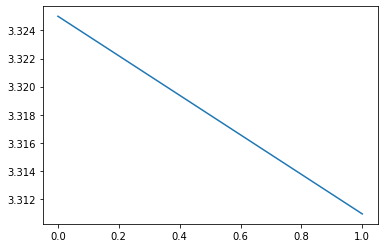

----------------------------------------
epoch: 2
train loss: 3.056459e+00    processed: 12800(34%)    0m0sec
train loss: 2.944353e+00    processed: 25600(69%)    0m0sec


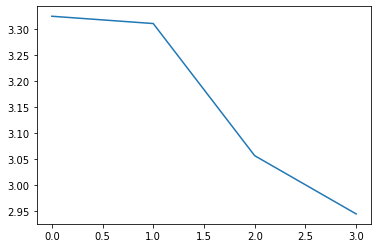

----------------------------------------
epoch: 3
train loss: 2.843786e+00    processed: 12800(34%)    0m0sec
train loss: 2.713379e+00    processed: 25600(69%)    0m0sec


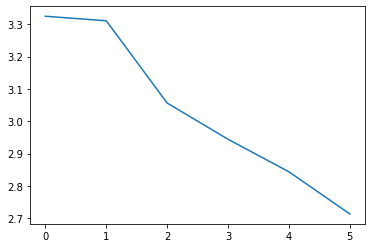

----------------------------------------
epoch: 4
train loss: 2.504393e+00    processed: 12800(34%)    0m0sec
train loss: 2.530573e+00    processed: 25600(69%)    0m0sec


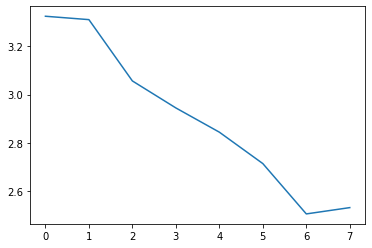

----------------------------------------
epoch: 5
train loss: 2.229604e+00    processed: 12800(34%)    0m0sec
train loss: 2.193140e+00    processed: 25600(69%)    0m0sec


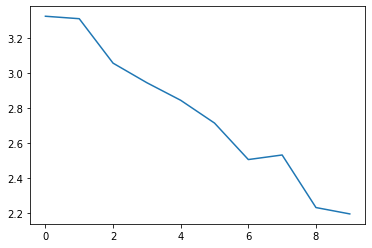

----------------------------------------
epoch: 6
train loss: 2.014135e+00    processed: 12800(34%)    0m0sec
train loss: 1.908570e+00    processed: 25600(69%)    0m0sec


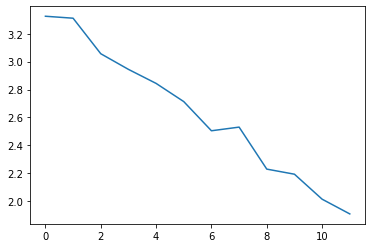

----------------------------------------
epoch: 7
train loss: 1.826056e+00    processed: 12800(34%)    0m0sec
train loss: 1.792924e+00    processed: 25600(69%)    0m0sec


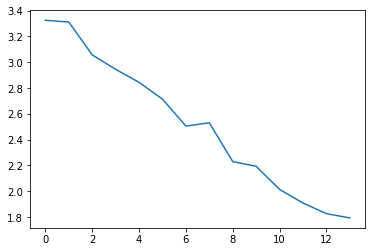

----------------------------------------
epoch: 8
train loss: 1.704982e+00    processed: 12800(34%)    0m0sec
train loss: 1.552963e+00    processed: 25600(69%)    0m0sec


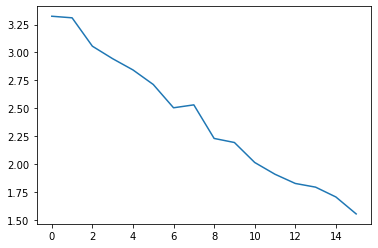

----------------------------------------
epoch: 9
train loss: 1.432694e+00    processed: 12800(34%)    0m0sec
train loss: 1.404710e+00    processed: 25600(69%)    0m0sec


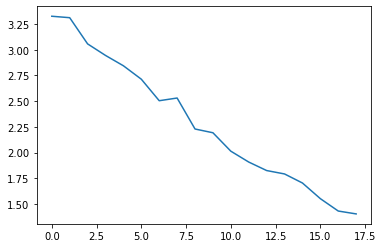

----------------------------------------
epoch: 10
train loss: 1.319487e+00    processed: 12800(34%)    0m0sec
train loss: 1.311656e+00    processed: 25600(69%)    0m0sec


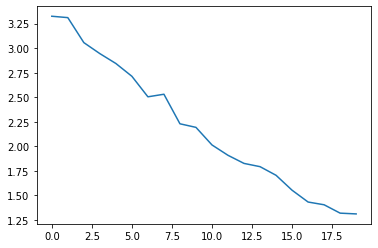

----------------------------------------
epoch: 11
train loss: 1.159389e+00    processed: 12800(34%)    0m0sec
train loss: 1.189173e+00    processed: 25600(69%)    0m0sec


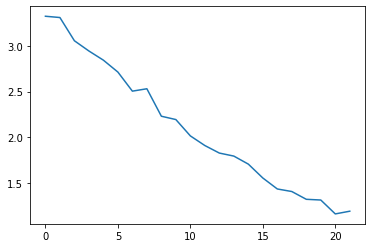

----------------------------------------
epoch: 12
train loss: 1.068545e+00    processed: 12800(34%)    0m0sec
train loss: 1.071297e+00    processed: 25600(69%)    0m0sec


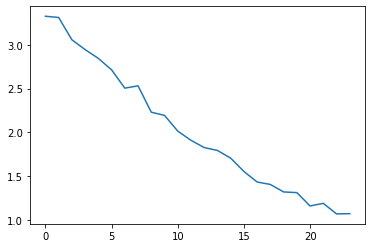

----------------------------------------
epoch: 13
train loss: 8.975828e-01    processed: 12800(34%)    0m0sec
train loss: 9.692864e-01    processed: 25600(69%)    0m0sec


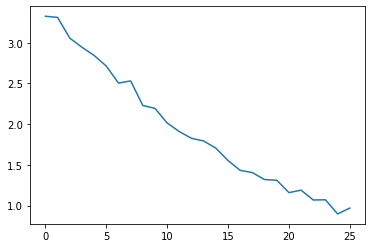

----------------------------------------
epoch: 14
train loss: 8.931952e-01    processed: 12800(34%)    0m0sec
train loss: 8.289963e-01    processed: 25600(69%)    0m0sec


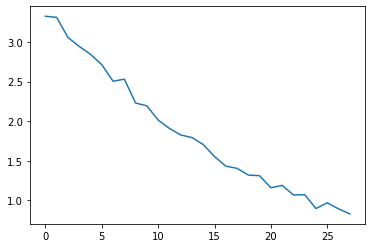

----------------------------------------
epoch: 15
train loss: 7.907481e-01    processed: 12800(34%)    0m0sec
train loss: 7.890718e-01    processed: 25600(69%)    0m0sec


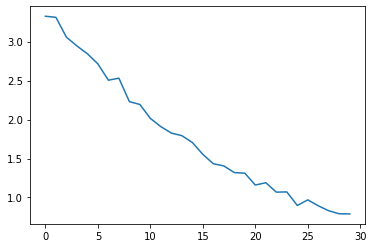

----------------------------------------
epoch: 16
train loss: 7.095440e-01    processed: 12800(34%)    0m0sec
train loss: 7.171440e-01    processed: 25600(69%)    0m0sec


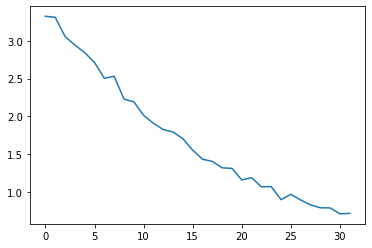

----------------------------------------
epoch: 17
train loss: 6.556721e-01    processed: 12800(34%)    0m0sec
train loss: 6.432214e-01    processed: 25600(69%)    0m0sec


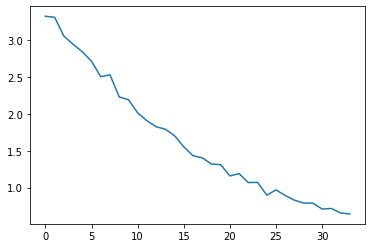

----------------------------------------
epoch: 18
train loss: 5.789633e-01    processed: 12800(34%)    0m0sec
train loss: 5.379550e-01    processed: 25600(69%)    0m0sec


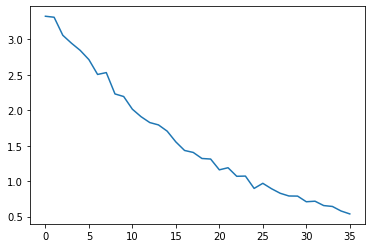

----------------------------------------
epoch: 19
train loss: 5.491678e-01    processed: 12800(34%)    0m0sec
train loss: 5.168558e-01    processed: 25600(69%)    0m0sec


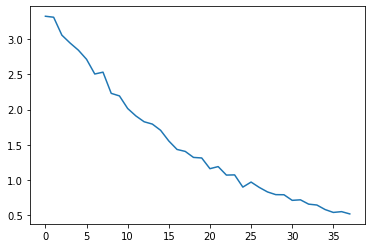

----------------------------------------
epoch: 20
train loss: 4.974730e-01    processed: 12800(34%)    0m0sec
train loss: 4.666898e-01    processed: 25600(69%)    0m0sec


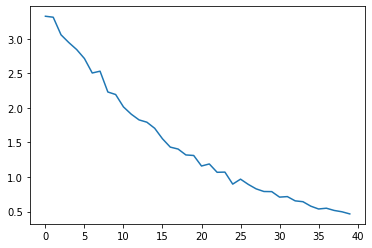

----------------------------------------
epoch: 21
train loss: 4.065884e-01    processed: 12800(34%)    0m0sec
train loss: 4.169974e-01    processed: 25600(69%)    0m0sec


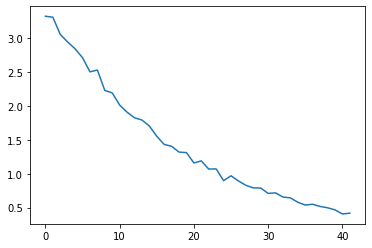

----------------------------------------
epoch: 22
train loss: 4.337839e-01    processed: 12800(34%)    0m0sec
train loss: 3.536770e-01    processed: 25600(69%)    0m0sec


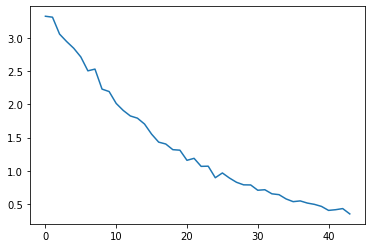

----------------------------------------
epoch: 23
train loss: 4.051724e-01    processed: 12800(34%)    0m0sec
train loss: 3.412708e-01    processed: 25600(69%)    0m0sec


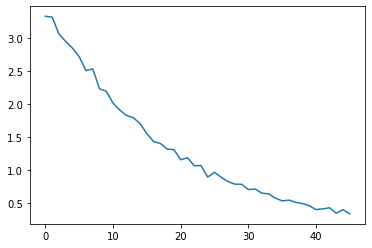

----------------------------------------
epoch: 24
train loss: 3.588028e-01    processed: 12800(34%)    0m0sec
train loss: 3.119962e-01    processed: 25600(69%)    0m0sec


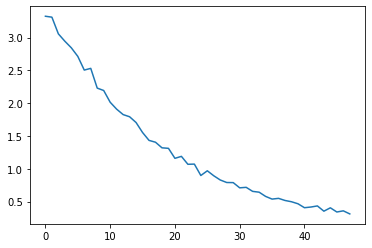

----------------------------------------
epoch: 25
train loss: 3.347573e-01    processed: 12800(34%)    0m0sec
train loss: 3.247172e-01    processed: 25600(69%)    0m0sec


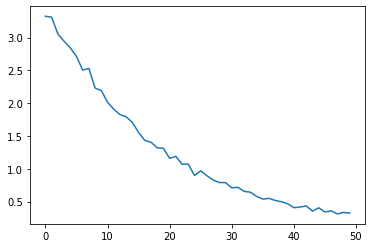

----------------------------------------
epoch: 26
train loss: 2.722431e-01    processed: 12800(34%)    0m0sec
train loss: 2.501959e-01    processed: 25600(69%)    0m0sec


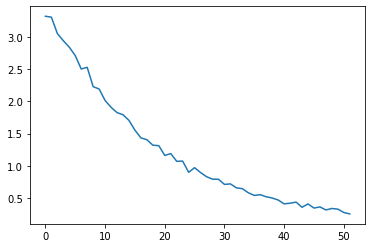

----------------------------------------
epoch: 27
train loss: 2.843147e-01    processed: 12800(34%)    0m0sec
train loss: 2.610043e-01    processed: 25600(69%)    0m0sec


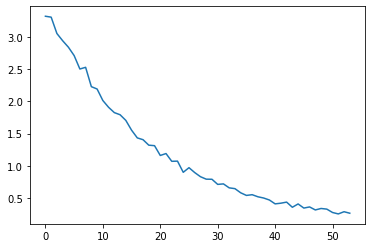

----------------------------------------
epoch: 28
train loss: 2.635595e-01    processed: 12800(34%)    0m0sec
train loss: 2.297079e-01    processed: 25600(69%)    0m0sec


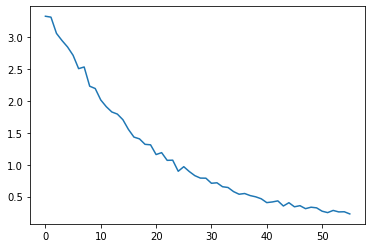

----------------------------------------
epoch: 29
train loss: 2.464480e-01    processed: 12800(34%)    0m0sec
train loss: 2.375812e-01    processed: 25600(69%)    0m0sec


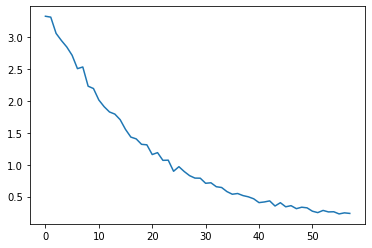

----------------------------------------
epoch: 30
train loss: 2.324423e-01    processed: 12800(34%)    0m0sec
train loss: 2.258672e-01    processed: 25600(69%)    0m0sec


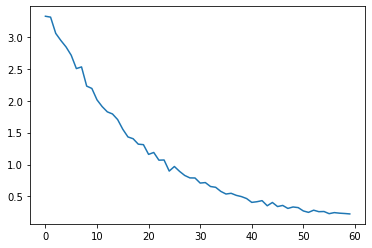

----------------------------------------
epoch: 31
train loss: 1.998026e-01    processed: 12800(34%)    0m0sec
train loss: 2.018374e-01    processed: 25600(69%)    0m0sec


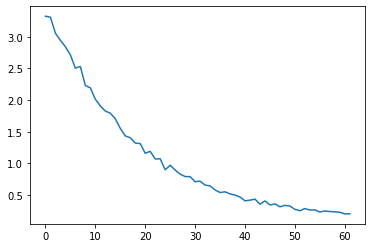

----------------------------------------
epoch: 32
train loss: 2.137573e-01    processed: 12800(34%)    0m0sec
train loss: 2.091395e-01    processed: 25600(69%)    0m0sec


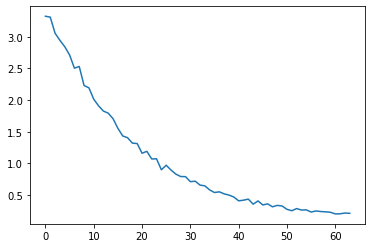

----------------------------------------
epoch: 33
train loss: 2.150287e-01    processed: 12800(34%)    0m0sec
train loss: 1.831298e-01    processed: 25600(69%)    0m0sec


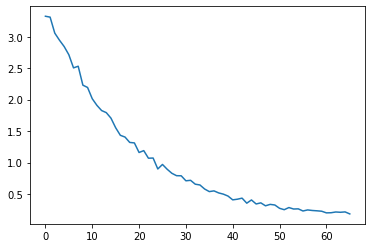

----------------------------------------
epoch: 34
train loss: 1.745660e-01    processed: 12800(34%)    0m0sec
train loss: 1.764361e-01    processed: 25600(69%)    0m0sec


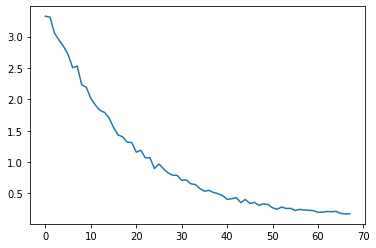

----------------------------------------
epoch: 35
train loss: 1.592044e-01    processed: 12800(34%)    0m0sec
train loss: 1.791279e-01    processed: 25600(69%)    0m0sec


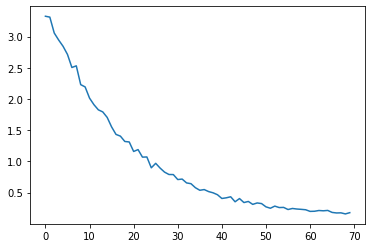

----------------------------------------
epoch: 36
train loss: 1.798948e-01    processed: 12800(34%)    0m0sec
train loss: 1.861975e-01    processed: 25600(69%)    0m0sec


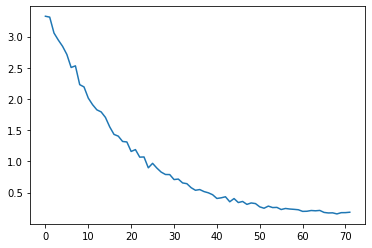

----------------------------------------
epoch: 37
train loss: 1.650918e-01    processed: 12800(34%)    0m0sec
train loss: 1.535879e-01    processed: 25600(69%)    0m0sec


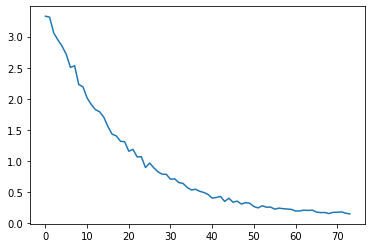

----------------------------------------
epoch: 38
train loss: 1.756062e-01    processed: 12800(34%)    0m0sec
train loss: 1.303567e-01    processed: 25600(69%)    0m0sec


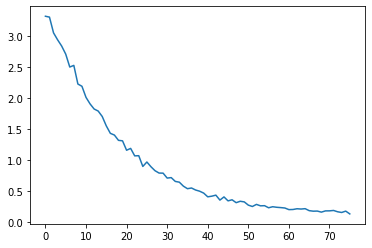

----------------------------------------
epoch: 39
train loss: 1.253854e-01    processed: 12800(34%)    0m0sec
train loss: 1.943522e-01    processed: 25600(69%)    0m0sec


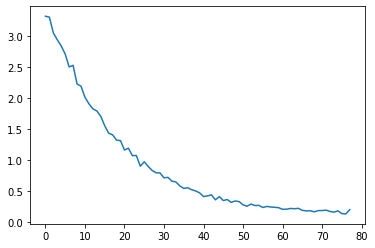

----------------------------------------
epoch: 40
train loss: 1.588053e-01    processed: 12800(34%)    0m0sec
train loss: 1.653208e-01    processed: 25600(69%)    0m0sec


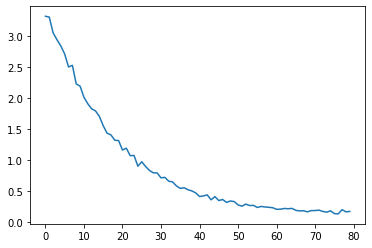

----------------------------------------
epoch: 41
train loss: 1.196754e-01    processed: 12800(34%)    0m0sec
train loss: 1.230592e-01    processed: 25600(69%)    0m0sec


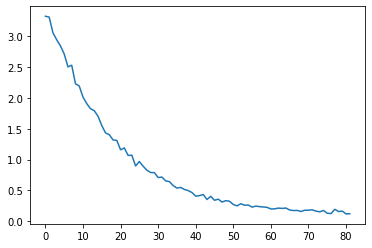

----------------------------------------
epoch: 42
train loss: 1.566680e-01    processed: 12800(34%)    0m0sec
train loss: 1.523621e-01    processed: 25600(69%)    0m0sec


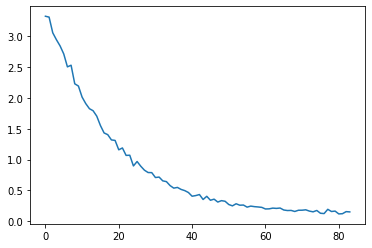

----------------------------------------
epoch: 43
train loss: 1.735216e-01    processed: 12800(34%)    0m0sec
train loss: 1.532143e-01    processed: 25600(69%)    0m0sec


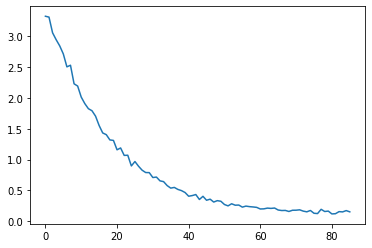

----------------------------------------
epoch: 44
train loss: 1.518296e-01    processed: 12800(34%)    0m0sec
train loss: 1.356512e-01    processed: 25600(69%)    0m0sec


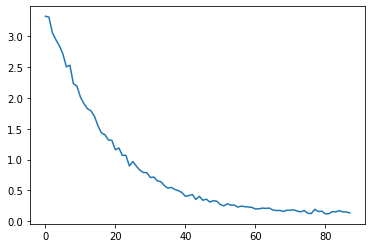

----------------------------------------
epoch: 45
train loss: 1.098000e-01    processed: 12800(34%)    0m0sec
train loss: 1.441456e-01    processed: 25600(69%)    0m0sec


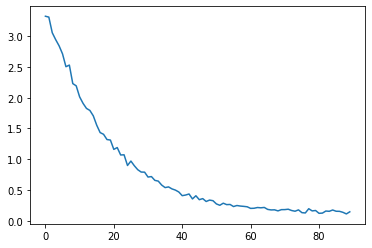

----------------------------------------
epoch: 46
train loss: 1.466211e-01    processed: 12800(34%)    0m0sec
train loss: 1.338829e-01    processed: 25600(69%)    0m0sec


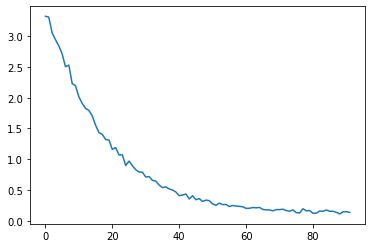

----------------------------------------
epoch: 47
train loss: 1.497512e-01    processed: 12800(34%)    0m0sec
train loss: 1.463413e-01    processed: 25600(69%)    0m0sec


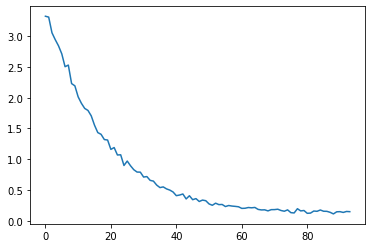

----------------------------------------
epoch: 48
train loss: 1.334108e-01    processed: 12800(34%)    0m0sec
train loss: 1.284236e-01    processed: 25600(69%)    0m0sec


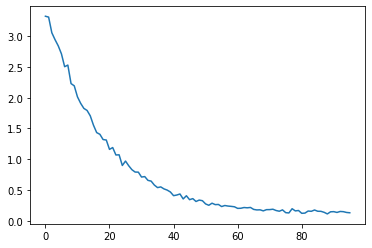

----------------------------------------
epoch: 49
train loss: 1.435513e-01    processed: 12800(34%)    0m0sec
train loss: 1.465456e-01    processed: 25600(69%)    0m0sec


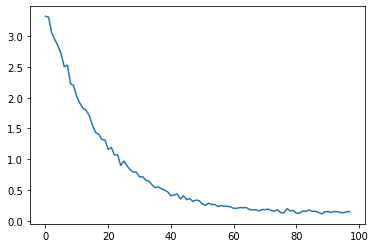

----------------------------------------
epoch: 50
train loss: 1.336059e-01    processed: 12800(34%)    0m0sec
train loss: 1.213866e-01    processed: 25600(69%)    0m0sec


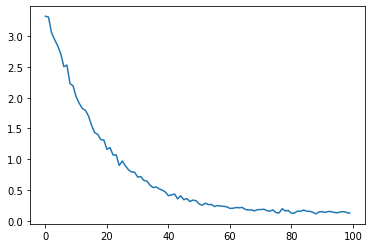

----------------------------------------
epoch: 51
train loss: 1.197312e-01    processed: 12800(34%)    0m0sec
train loss: 1.262662e-01    processed: 25600(69%)    0m0sec


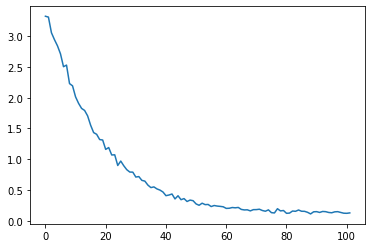

----------------------------------------
epoch: 52
train loss: 9.871288e-02    processed: 12800(34%)    0m0sec
train loss: 1.299656e-01    processed: 25600(69%)    0m0sec


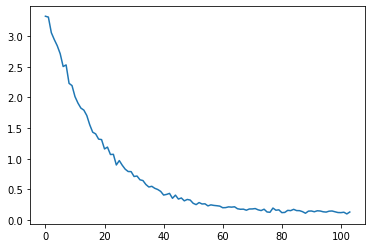

----------------------------------------
epoch: 53
train loss: 1.478294e-01    processed: 12800(34%)    0m0sec
train loss: 1.275633e-01    processed: 25600(69%)    0m0sec


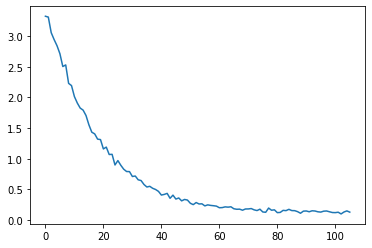

----------------------------------------
epoch: 54
train loss: 1.181095e-01    processed: 12800(34%)    0m0sec
train loss: 1.141685e-01    processed: 25600(69%)    0m0sec


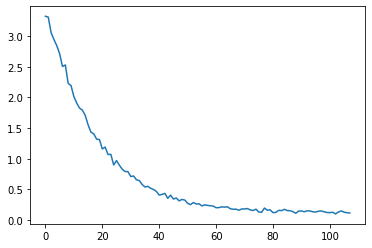

----------------------------------------
epoch: 55
train loss: 1.168608e-01    processed: 12800(34%)    0m0sec
train loss: 1.190414e-01    processed: 25600(69%)    0m0sec


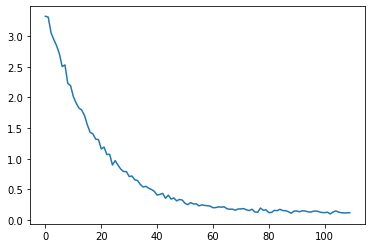

----------------------------------------
epoch: 56
train loss: 1.093292e-01    processed: 12800(34%)    0m0sec
train loss: 1.030480e-01    processed: 25600(69%)    0m0sec


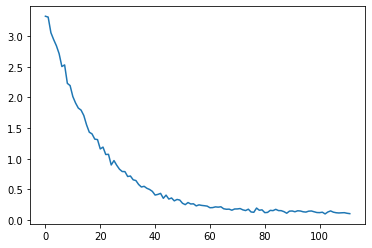

----------------------------------------
epoch: 57
train loss: 9.233500e-02    processed: 12800(34%)    0m0sec
train loss: 1.281198e-01    processed: 25600(69%)    0m0sec


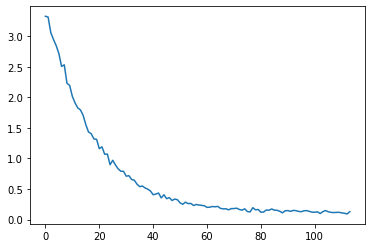

----------------------------------------
epoch: 58
train loss: 1.504520e-01    processed: 12800(34%)    0m0sec
train loss: 1.169487e-01    processed: 25600(69%)    0m0sec


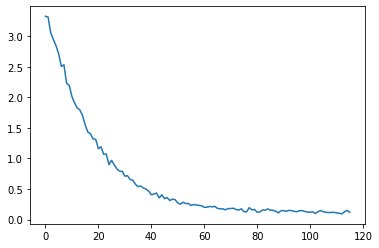

----------------------------------------
epoch: 59
train loss: 1.135788e-01    processed: 12800(34%)    0m0sec
train loss: 1.334664e-01    processed: 25600(69%)    0m0sec


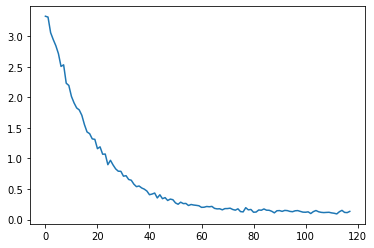

----------------------------------------
epoch: 60
train loss: 1.312122e-01    processed: 12800(34%)    0m0sec
train loss: 1.212470e-01    processed: 25600(69%)    0m0sec


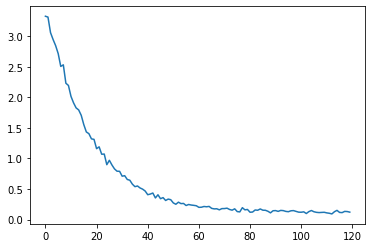

----------------------------------------
epoch: 61
train loss: 1.025970e-01    processed: 12800(34%)    0m0sec
train loss: 1.203223e-01    processed: 25600(69%)    0m0sec


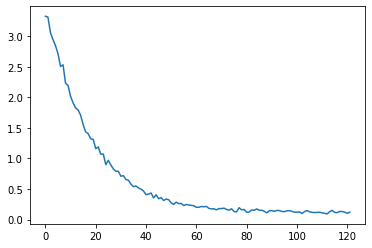

----------------------------------------
epoch: 62
train loss: 1.297945e-01    processed: 12800(34%)    0m0sec
train loss: 1.155443e-01    processed: 25600(69%)    0m0sec


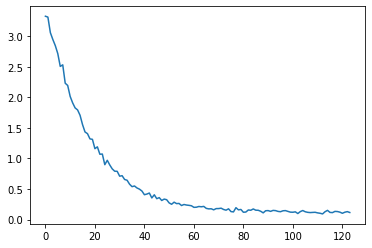

----------------------------------------
epoch: 63
train loss: 1.046294e-01    processed: 12800(34%)    0m0sec
train loss: 1.295850e-01    processed: 25600(69%)    0m0sec


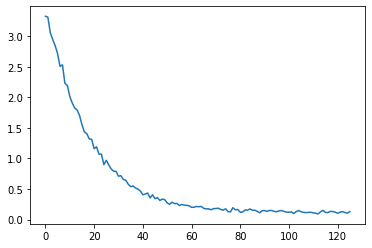

----------------------------------------
epoch: 64
train loss: 1.264698e-01    processed: 12800(34%)    0m0sec
train loss: 1.200667e-01    processed: 25600(69%)    0m0sec


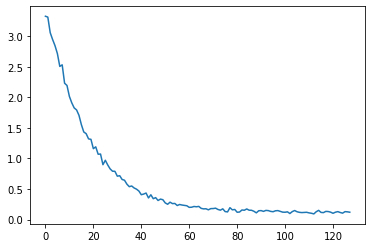

----------------------------------------
epoch: 65
train loss: 8.772243e-02    processed: 12800(34%)    0m0sec
train loss: 1.108310e-01    processed: 25600(69%)    0m0sec


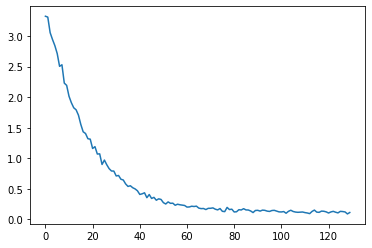

----------------------------------------
epoch: 66
train loss: 9.025421e-02    processed: 12800(34%)    0m0sec
train loss: 1.102255e-01    processed: 25600(69%)    0m0sec


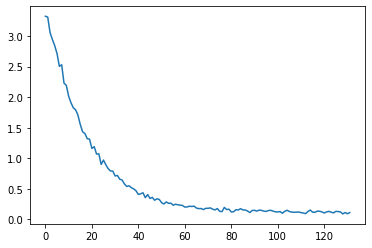

----------------------------------------
epoch: 67
train loss: 1.414107e-01    processed: 12800(34%)    0m0sec
train loss: 9.970144e-02    processed: 25600(69%)    0m0sec


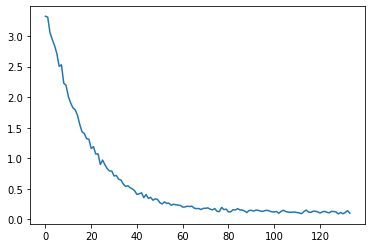

----------------------------------------
epoch: 68
train loss: 1.086593e-01    processed: 12800(34%)    0m0sec
train loss: 1.062322e-01    processed: 25600(69%)    0m0sec


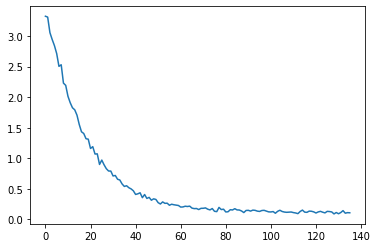

----------------------------------------
epoch: 69
train loss: 9.863131e-02    processed: 12800(34%)    0m0sec
train loss: 1.163748e-01    processed: 25600(69%)    0m0sec


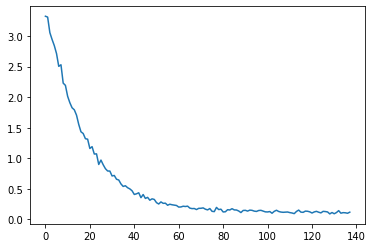

----------------------------------------
epoch: 70
train loss: 9.648301e-02    processed: 12800(34%)    0m0sec
train loss: 1.140557e-01    processed: 25600(69%)    0m0sec


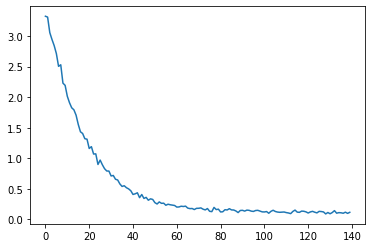

----------------------------------------
epoch: 71
train loss: 1.112426e-01    processed: 12800(34%)    0m0sec
train loss: 8.527577e-02    processed: 25600(69%)    0m0sec


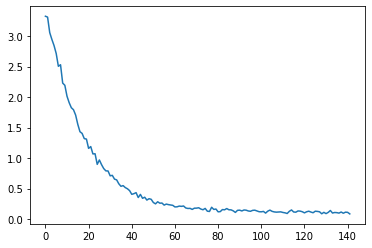

----------------------------------------
epoch: 72
train loss: 1.023400e-01    processed: 12800(34%)    0m0sec
train loss: 1.030816e-01    processed: 25600(69%)    0m0sec


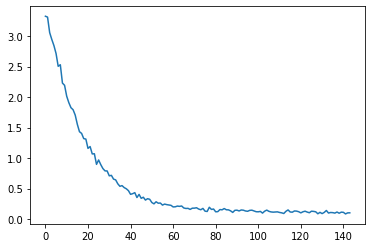

----------------------------------------
epoch: 73
train loss: 9.595161e-02    processed: 12800(34%)    0m0sec
train loss: 1.153468e-01    processed: 25600(69%)    0m0sec


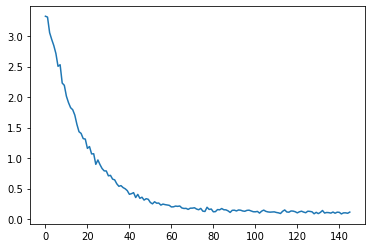

----------------------------------------
epoch: 74
train loss: 1.097538e-01    processed: 12800(34%)    0m0sec
train loss: 1.230690e-01    processed: 25600(69%)    0m0sec


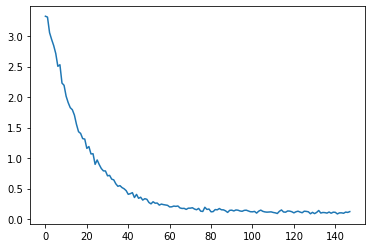

----------------------------------------
epoch: 75
train loss: 9.606236e-02    processed: 12800(34%)    0m0sec
train loss: 8.578263e-02    processed: 25600(69%)    0m0sec


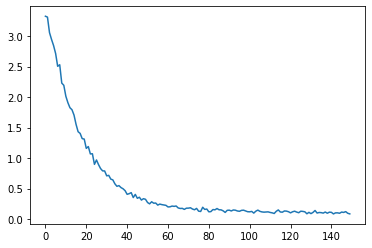

----------------------------------------
epoch: 76
train loss: 1.372280e-01    processed: 12800(34%)    0m0sec
train loss: 1.251348e-01    processed: 25600(69%)    0m0sec


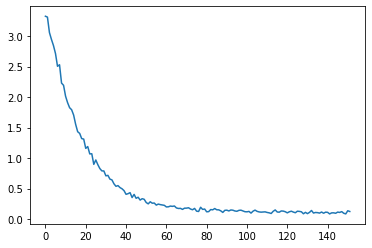

----------------------------------------
epoch: 77
train loss: 1.016182e-01    processed: 12800(34%)    0m0sec
train loss: 1.154011e-01    processed: 25600(69%)    0m0sec


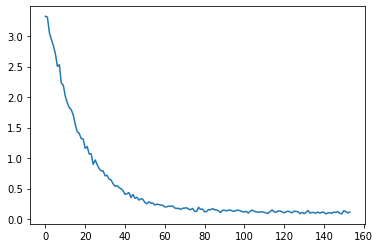

----------------------------------------
epoch: 78
train loss: 1.148093e-01    processed: 12800(34%)    0m0sec
train loss: 9.739772e-02    processed: 25600(69%)    0m0sec


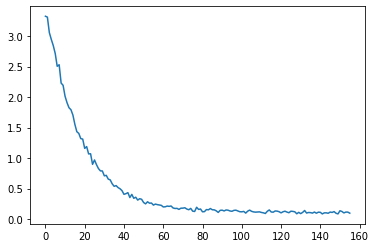

----------------------------------------
epoch: 79
train loss: 1.048918e-01    processed: 12800(34%)    0m0sec
train loss: 1.094296e-01    processed: 25600(69%)    0m0sec


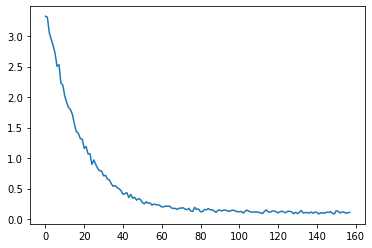

----------------------------------------
epoch: 80
train loss: 8.052557e-02    processed: 12800(34%)    0m0sec
train loss: 1.024869e-01    processed: 25600(69%)    0m0sec


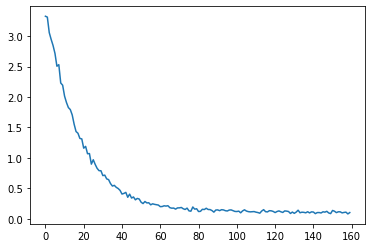

----------------------------------------
epoch: 81
train loss: 8.374693e-02    processed: 12800(34%)    0m0sec
train loss: 1.184085e-01    processed: 25600(69%)    0m0sec


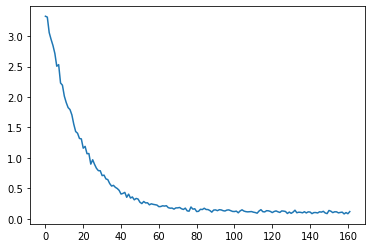

----------------------------------------
epoch: 82
train loss: 1.041710e-01    processed: 12800(34%)    0m0sec
train loss: 9.972628e-02    processed: 25600(69%)    0m0sec


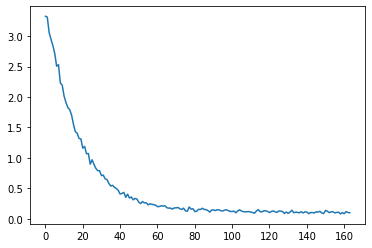

----------------------------------------
epoch: 83
train loss: 9.232775e-02    processed: 12800(34%)    0m0sec
train loss: 1.012889e-01    processed: 25600(69%)    0m0sec


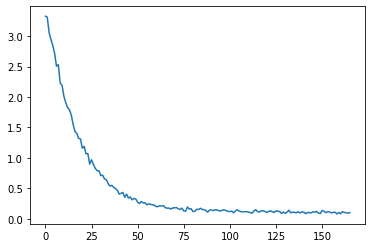

----------------------------------------
epoch: 84
train loss: 1.071066e-01    processed: 12800(34%)    0m0sec
train loss: 1.090871e-01    processed: 25600(69%)    0m0sec


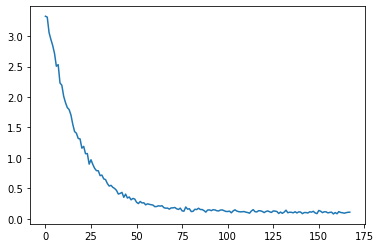

----------------------------------------
epoch: 85
train loss: 1.123001e-01    processed: 12800(34%)    0m0sec
train loss: 9.876565e-02    processed: 25600(69%)    0m0sec


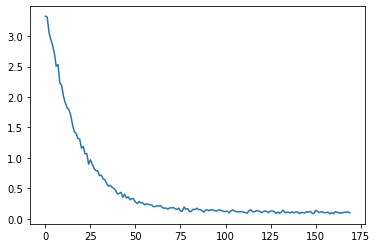

----------------------------------------
epoch: 86
train loss: 7.995249e-02    processed: 12800(34%)    0m0sec
train loss: 1.099148e-01    processed: 25600(69%)    0m0sec


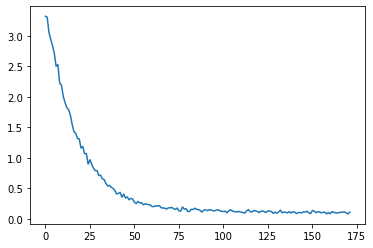

----------------------------------------
epoch: 87
train loss: 8.437075e-02    processed: 12800(34%)    0m0sec
train loss: 7.275916e-02    processed: 25600(69%)    0m0sec


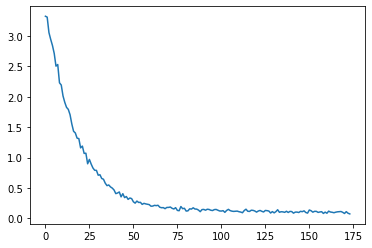

----------------------------------------
epoch: 88
train loss: 9.562753e-02    processed: 12800(34%)    0m0sec
train loss: 1.188492e-01    processed: 25600(69%)    0m0sec


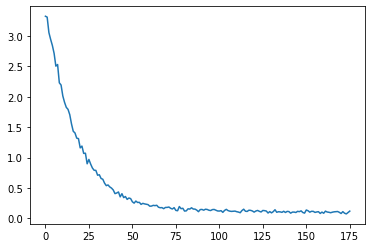

----------------------------------------
epoch: 89
train loss: 1.008576e-01    processed: 12800(34%)    0m0sec
train loss: 9.845156e-02    processed: 25600(69%)    0m0sec


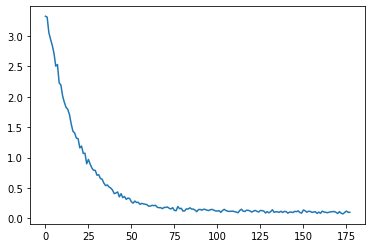

----------------------------------------
epoch: 90
train loss: 8.460489e-02    processed: 12800(34%)    0m0sec
train loss: 1.019056e-01    processed: 25600(69%)    0m0sec


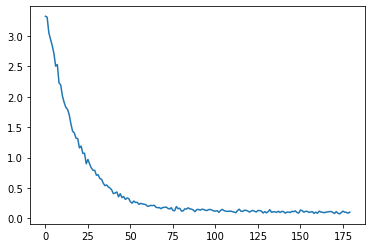

----------------------------------------
epoch: 91
train loss: 8.168605e-02    processed: 12800(34%)    0m0sec
train loss: 9.470280e-02    processed: 25600(69%)    0m0sec


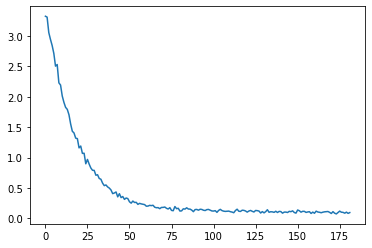

----------------------------------------
epoch: 92


KeyboardInterrupt: 

In [81]:
if __name__ == '__main__':
    # 諸々のサイズ
    batch_size = 128
    # Model 定義
    user_num = len(user2idx) + 1
    item_num = len(item2idx) + 1
    aspect_num = 6
    embed_size1 = 32
    embed_size2 = 32
    model = Zhang(user_num, item_num, aspect_num, embed_size1, embed_size2).to(device)
    
    epoch = 1000
    evaluate_every = 5 #evaluate_everyごとにtestデータのndcgを計算
    n_iter = int(len(train_data) / batch_size)
    loss_list = []
    ndcg_list = []
    lr = 0.001
    decay_every = 10
    for i in range(epoch):
        print('epoch: {}'.format(i+1))
        loss_list.extend(iterate_train(model, n_iter=n_iter, batch_size=batch_size, learning_rate=lr, print_every=100, plot_every=100))
        '''
        if i % evaluate_every == 0:
            #roc_auc = evaluate_ranking(rnn, metric='roc_auc')
            start = time.time()
            pr_auc, roc_auc = evaluate_ranking(model, metric='map')
            mi, sec = time_since(time.time() - start)
            print('pr_roc :{}'.format(pr_auc))
            print('roc_auc :{}'.format(roc_auc))
            print('{}m{}sec'.format(mi, sec))
            
            # modelを保存する
            # model_name = 'gru_epoch' + str(i) + '.pickle'
            # with open('./rnn_atten_model/' + model_name, 'wb') as f:
            #    pickle.dump(model, f)
                            
        '''
                            
        plt.plot(loss_list)
        plt.show()
        
        if (i+1) % decay_every == 0:
            #lr = lr / 2
            lr = lr * 0.8
        
        print('-'*40)

In [39]:
def test(): 
    # 諸々のサイズ
    batch_size = 512
    # Model 定義
    user_num = len(user_list)
    item_num = len(item_list)
    aspect_num = 6
    embed_size1 = 32
    embed_size2 = 32
    model = Zhang(user_num, item_num, aspect_num, embed_size1, embed_size2).to(device)
    
    epoch = 2
    evaluate_every = 1 #evaluate_everyごとにtestデータのndcgを計算
    n_iter = int(len(train_data) / batch_size)
    loss_list = []
    ndcg_list = []
    lr = 0.001
    decay_every = 10
    for i in range(epoch):
        print('epoch: {}'.format(i+1))
        loss_list.extend(iterate_train(model, n_iter=1000, batch_size=batch_size, learning_rate=lr, print_every=1, plot_every=1))
        
        if i % evaluate_every == 0:
            #roc_auc = evaluate_ranking(rnn, metric='roc_auc')
            pr_auc, roc_auc = evaluate_ranking(model, metric='map')
            print('pr_roc :{}'.format(pr_auc))
            print('roc_auc :{}'.format(roc_auc))
            
            # modelを保存する
            model_name = 'gru_epoch' + str(i) + '.pickle'
            with open('./rnn_atten_model/' + model_name, 'wb') as f:
                pickle.dump(model, f)
                            
                            
        plt.plot(loss_list)
        plt.show()
        
        if (i+1) % decay_every == 0:
            #lr = lr / 2
            lr = lr * 0.8
        
        print('-'*40)